# Análise exploratória de Banking Customer Churn Prediction
Leia mais sobre o projeto e conjunto de dados [index.md](../docs/index.md).

In [1]:
# import libraries

from IPython.display import display, Markdown

import mlflow
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np
import plotly.graph_objects as go
import plotly.express as px
from matplotlib.colors import LinearSegmentedColormap
from scipy import stats
import os
import warnings

colors = ['#8EB19D', '#817E9F', '#634B66'] 
sns.set_style("darkgrid")

custom_colormap = LinearSegmentedColormap.from_list("custom_cmap", colors, N=256)

warnings.filterwarnings('ignore')

## 1. Coleta de dados

In [2]:
df = pd.read_csv('../data/raw/Churn_Modelling.csv')
df.shape

(10000, 14)

In [3]:
pd.concat([df.head(10), df.info()])

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10000 entries, 0 to 9999
Data columns (total 14 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   RowNumber        10000 non-null  int64  
 1   CustomerId       10000 non-null  int64  
 2   Surname          10000 non-null  object 
 3   CreditScore      10000 non-null  int64  
 4   Geography        10000 non-null  object 
 5   Gender           10000 non-null  object 
 6   Age              10000 non-null  int64  
 7   Tenure           10000 non-null  int64  
 8   Balance          10000 non-null  float64
 9   NumOfProducts    10000 non-null  int64  
 10  HasCrCard        10000 non-null  int64  
 11  IsActiveMember   10000 non-null  int64  
 12  EstimatedSalary  10000 non-null  float64
 13  Exited           10000 non-null  int64  
dtypes: float64(2), int64(9), object(3)
memory usage: 1.1+ MB


,RowNumber,CustomerId,Surname,CreditScore,Geography,Gender,Age,Tenure,Balance,NumOfProducts,HasCrCard,IsActiveMember,EstimatedSalary,Exited
0,1,15634602,Hargrave,619,France,Female,42,2,0.00,1,1,1,101348.88,1
1,2,15647311,Hill,608,Spain,Female,41,1,83807.86,1,0,1,112542.58,0
2,3,15619304,Onio,502,France,Female,42,8,159660.80,3,1,0,113931.57,1
3,4,15701354,Boni,699,France,Female,39,1,0.00,2,0,0,93826.63,0
4,5,15737888,Mitchell,850,Spain,Female,43,2,125510.82,1,1,1,79084.10,0
5,6,15574012,Chu,645,Spain,Male,44,8,113755.78,2,1,0,149756.71,1
6,7,15647311,Bartlett,822,France,Male,50,7,0.00,2,1,1,10062.80,0
7,8,15656148,Obinna,376,Germany,Female,29,4,115046.74,4,1,0,119346.88,1
8,9,15792365,He,501,France,Male,44,4,142051.07,2,0,1,74940.50,0
9,10,15592389,H?,684,France,Male,27,2,134603.88,1,1,1,71725.73,0


## 2. Tratamento dos dados

In [4]:
df = df.drop(['RowNumber', 'CustomerId', 'Surname'], axis=1)
df.shape, df.isnull().sum().sum()

((10000, 11), 0)

## 3. Descrição dos dados
Segue o link para a descrição dos dados [data.md](../docs/data.md)

### 3.1. Dicionário de dados

In [5]:
dictionary = pd.read_csv('../data/external/dictionary.csv')
qualitatives = dictionary[dictionary['tipo'] == 'qualitativa'].variavel.tolist()
quantitatives = dictionary[dictionary['tipo'] == 'quantitativa'].variavel.tolist()
dictionary

,variavel,descricao,tipo,subtipo
0,Surname,O sobrenome do cliente,qualitativa,nominal
1,CreditScore,O score de crédito do cliente,quantitativa,discreta
2,Geography,A localização geográfica do cliente (por exemp...,qualitativa,nominal
3,Gender,O gênero do cliente,qualitativa,nominal
4,Age,A idade do cliente,quantitativa,discreta
5,Tenure,O número de anos que o cliente está no banco,quantitativa,discreta
6,Balance,O saldo da conta do cliente,quantitativa,continua
7,NumOfProducts,O número de produtos bancários que o cliente p...,quantitativa,discreta
8,HasCrCard,Indica se o cliente possui cartão de crédito (...,qualitativa,nominal
9,IsActiveMember,Indica se o cliente é um membro ativo (binário...,qualitativa,nominal


---
 - São 12 variáveis, com 6 qualitativas nominais, 2 quantitativas contínuas e 4 quantitativas discretas.
---

## 4. Perguntas de partida e hipóteses

### 1. Existem dados faltantes, se sim quantos e em quais variáveis?

In [6]:
number_of_na_by_column = df.isnull().sum().loc[lambda x: x > 0]
number_of_na_rows = df.isnull().any(axis=1).sum()

if number_of_na_rows > 0 and number_of_na_rows > 0:
    display(number_of_na_by_column)
    display(Markdown(
        "---\n"
        f"A partir dessa informação sabemos que as variáveis `{number_of_na_by_column.axes[0].to_list()}`"
        f"contém valores faltantes. Além disso sabemos que temos `{number_of_na_rows}` linhas com valores faltantes."
        "As próximas análises aqui serão realizadas sem considerar os dados faltantes"
        "\n\n ---"
    ))
else:
    display(Markdown("---\n"
                     "Não há dados faltantes/nan no conjunto de dados"
                     "\n\n---"))

df.dropna(inplace=True)

---
Não há dados faltantes/nan no conjunto de dados

---

### 2. Qual a distribuição dos dados (variável por variável)?

**Estatísticas descritivas**

In [7]:
df.describe(include='all')

,CreditScore,Geography,Gender,Age,Tenure,Balance,NumOfProducts,HasCrCard,IsActiveMember,EstimatedSalary,Exited
count,10000.000000,10000,10000,10000.000000,10000.000000,10000.000000,10000.000000,10000.00000,10000.000000,10000.000000,10000.000000
unique,NaN,3,2,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
top,NaN,France,Male,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
freq,NaN,5014,5457,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
mean,650.528800,NaN,NaN,38.921800,5.012800,76485.889288,1.530200,0.70550,0.515100,100090.239881,0.203700
std,96.653299,NaN,NaN,10.487806,2.892174,62397.405202,0.581654,0.45584,0.499797,57510.492818,0.402769
min,350.000000,NaN,NaN,18.000000,0.000000,0.000000,1.000000,0.00000,0.000000,11.580000,0.000000
25%,584.000000,NaN,NaN,32.000000,3.000000,0.000000,1.000000,0.00000,0.000000,51002.110000,0.000000
50%,652.000000,NaN,NaN,37.000000,5.000000,97198.540000,1.000000,1.00000,1.000000,100193.915000,0.000000
75%,718.000000,NaN,NaN,44.000000,7.000000,127644.240000,2.000000,1.00000,1.000000,149388.247500,0.000000


**Distribuição das variáveis qualitativas**


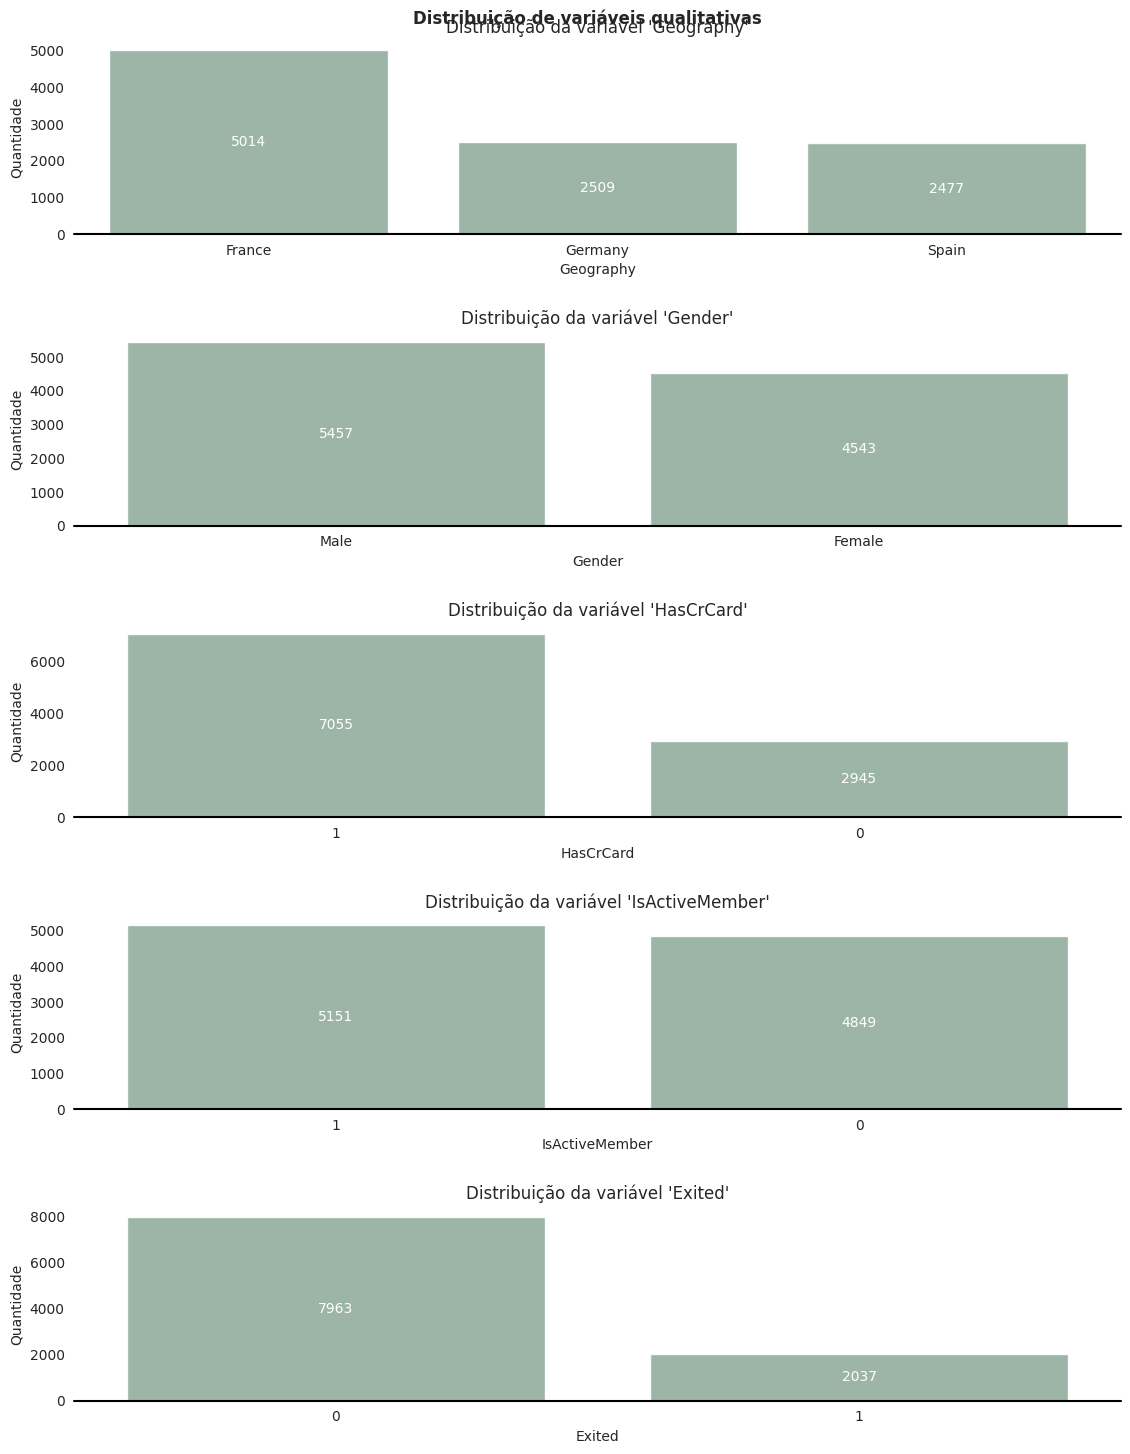

In [8]:
qualitatives.remove('Surname')
fig, axes = plt.subplots(len(qualitatives), 1, figsize=(12, len(qualitatives)*3))
plt.tight_layout(pad=4, w_pad=10, h_pad=5)
fig.suptitle('Distribuição de variáveis qualitativas', fontweight='bold')
for i, variavel in enumerate(qualitatives):
    order = df[variavel].value_counts().index
    ax = sns.countplot(
        data=df,
        x=variavel,
        ax=axes.flatten()[i],
        color=colors[0],
        alpha=0.9,
        order=order
    )
    ax.bar_label(
        ax.containers[0],
        fmt='%.0f',
        label_type='center',
        color='white'
    )
    ax.set(frame_on=False)
    ax.axhline(0, color="k", clip_on=False)
    ax.set_title(f"Distribuição da variável '{variavel}'")
    ax.set_ylabel('Quantidade')
    ax.grid(axis='y', linestyle='-')
plt.show()

#### 2.1. Como estão distribuídas as variáveis presentes no dataset?

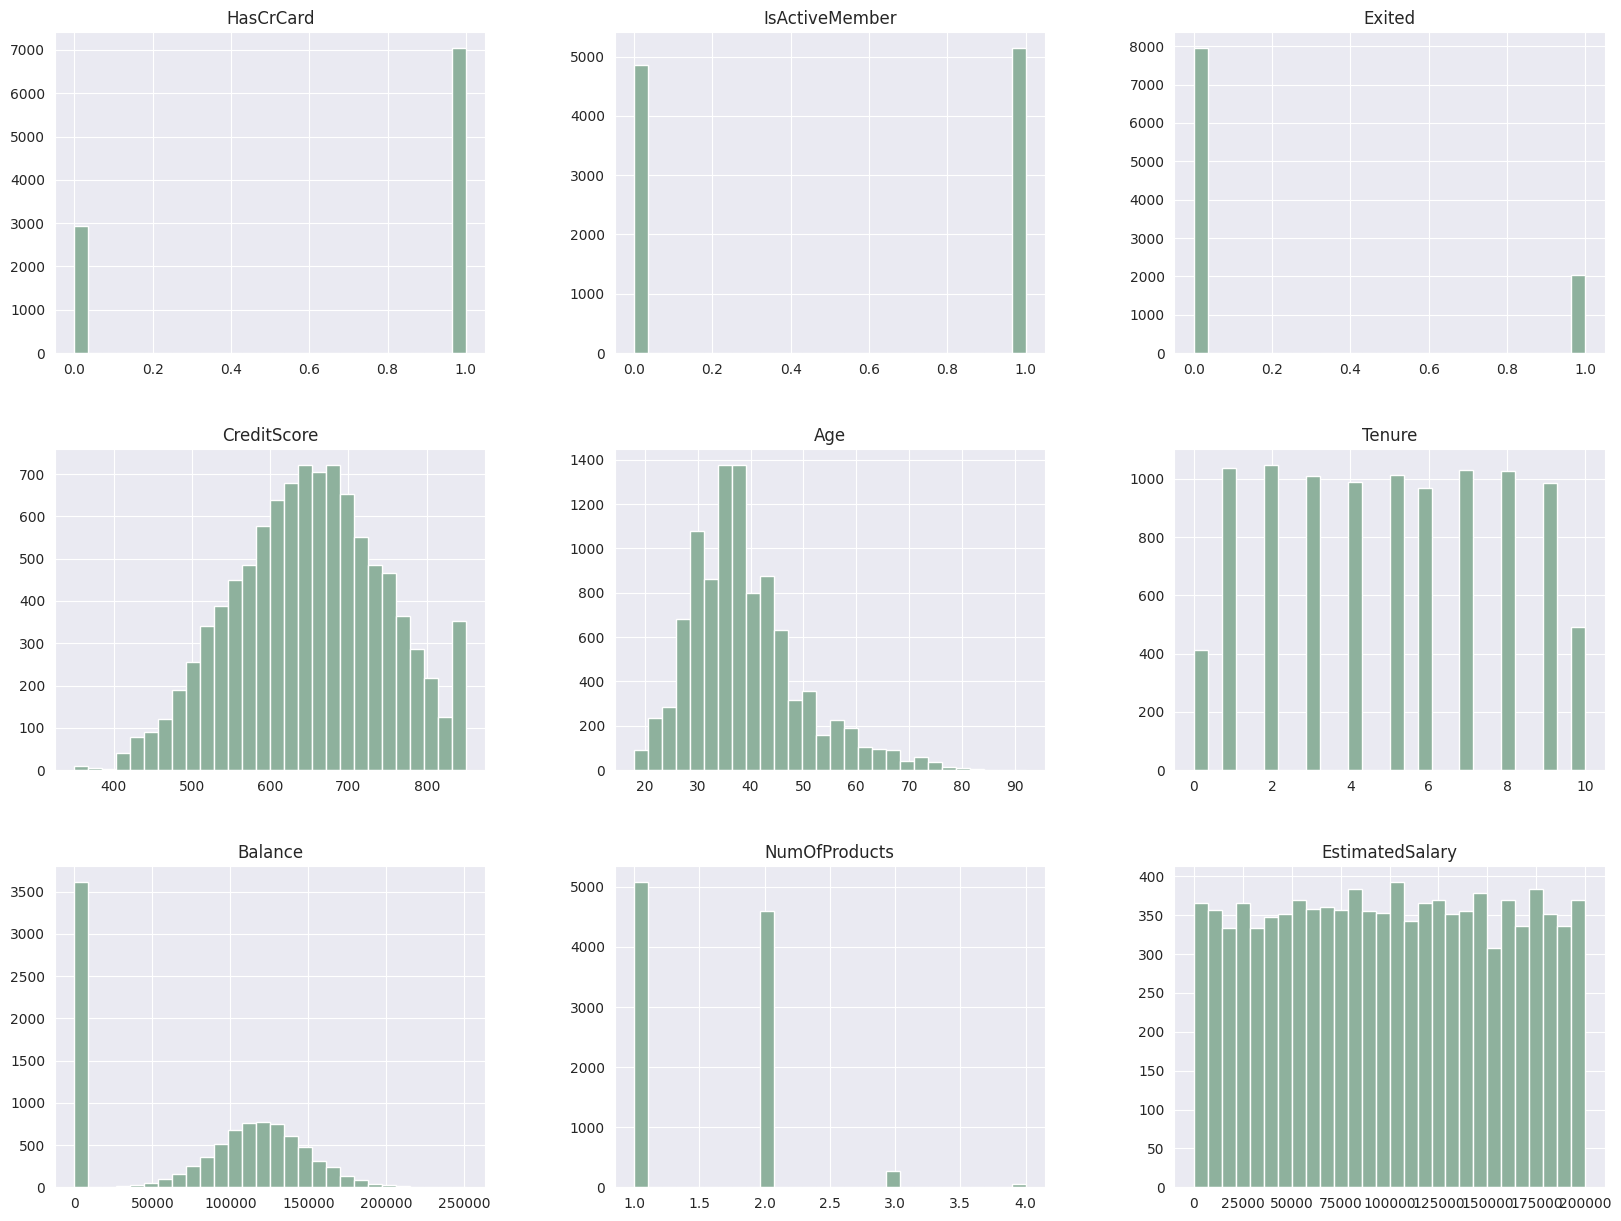

In [9]:
df[qualitatives+quantitatives].hist(bins=28, figsize=(20, 15), color=colors[0])
plt.show()

#### 2.2. Qual a relação das variáveis com a saída de um cliente do banco?

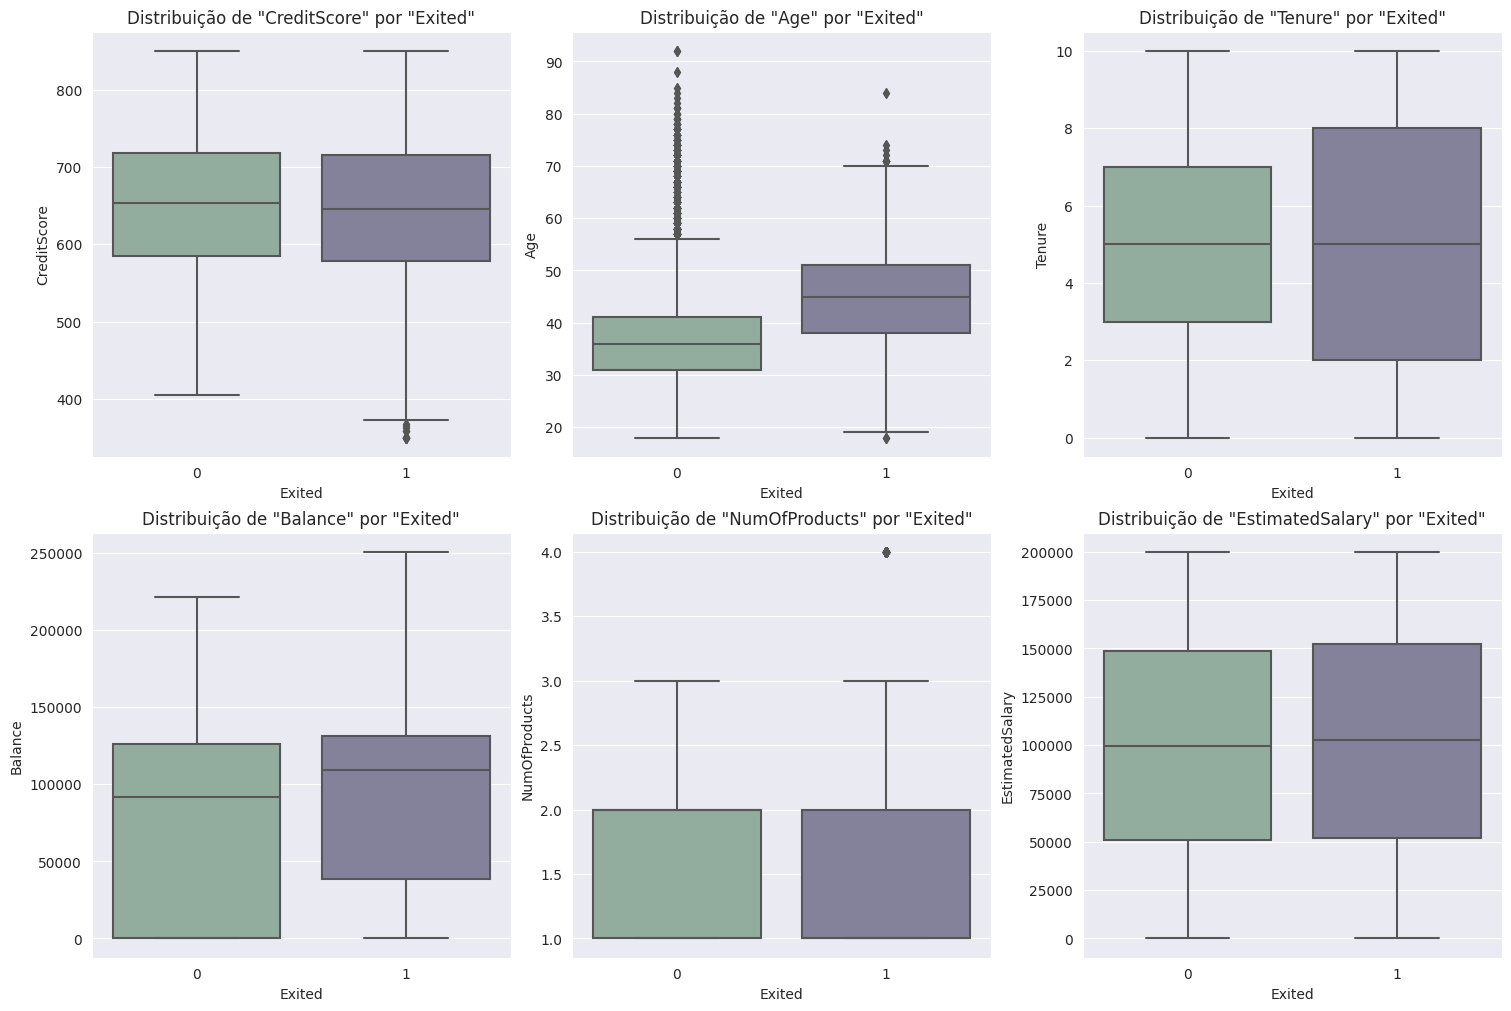

In [10]:
n_cols = len(quantitatives)
n_rows = 2
n_cols_per_row = (n_cols + 1) // n_rows  

fig, axes = plt.subplots(nrows=n_rows, ncols=n_cols_per_row, figsize=(15, 10), constrained_layout=True)
axes = axes.flatten()  

for ax, col in zip(axes, quantitatives):
    sns.boxplot(x='Exited', y=df[col], data=df, ax=ax, palette=colors) 
    ax.set_title(f'Distribuição de "{col}" por "Exited"')

for ax in axes[len(df):]:
    ax.set_visible(False)

plt.show()

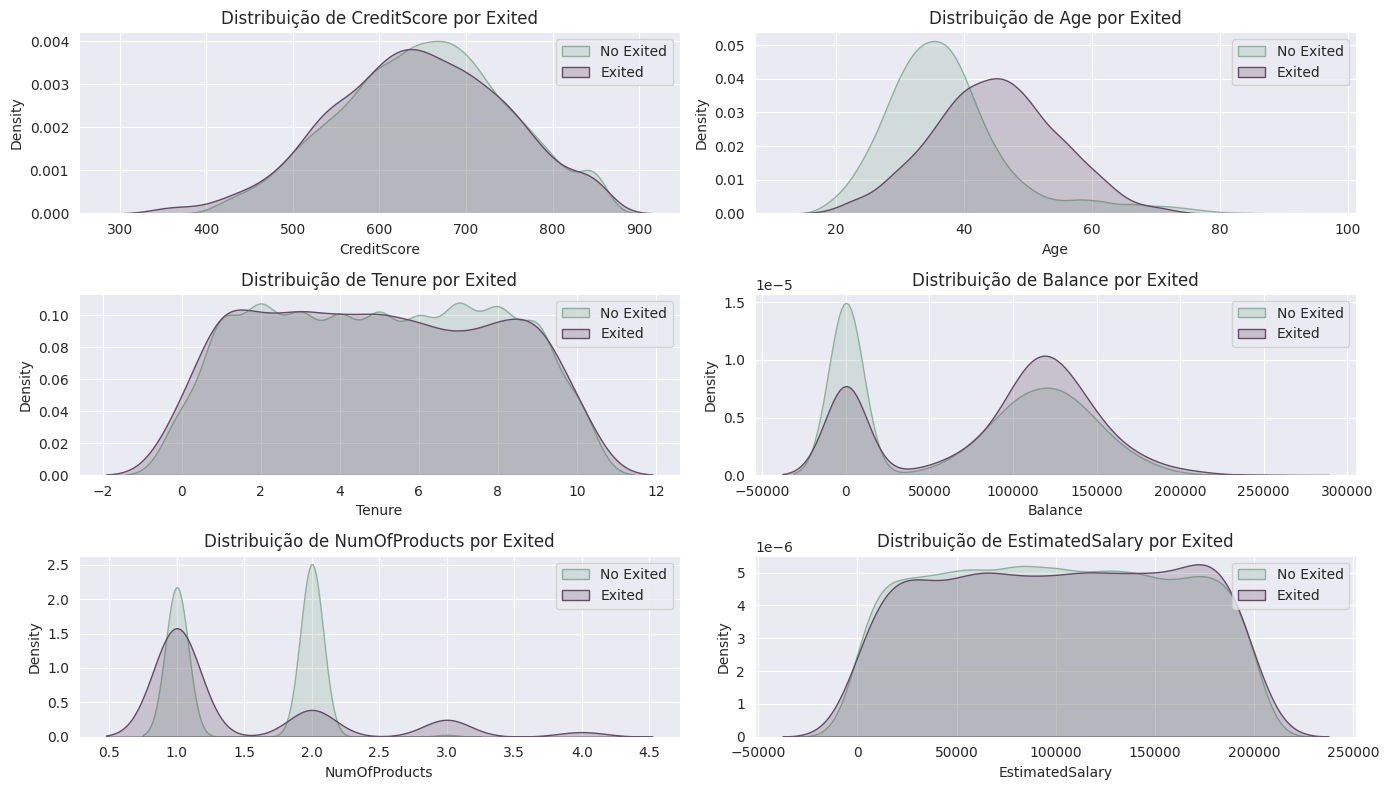

In [11]:
fig, axes = plt.subplots(nrows=3, ncols=2, figsize=(14, 8))
axes = axes.flatten()

for ax, col in zip(axes, quantitatives):
    sns.kdeplot(data=df[df['Exited'] == 0][col], ax=ax, label='No Exited', shade=True, color=colors[0])
    sns.kdeplot(data=df[df['Exited'] == 1][col], ax=ax, label='Exited', shade=True, color=colors[2])
    ax.set_title(f'Distribuição de {col} por Exited')
    ax.legend()

plt.tight_layout()
plt.show()

#### 2.3. Como é a correlação entre as variáveis?

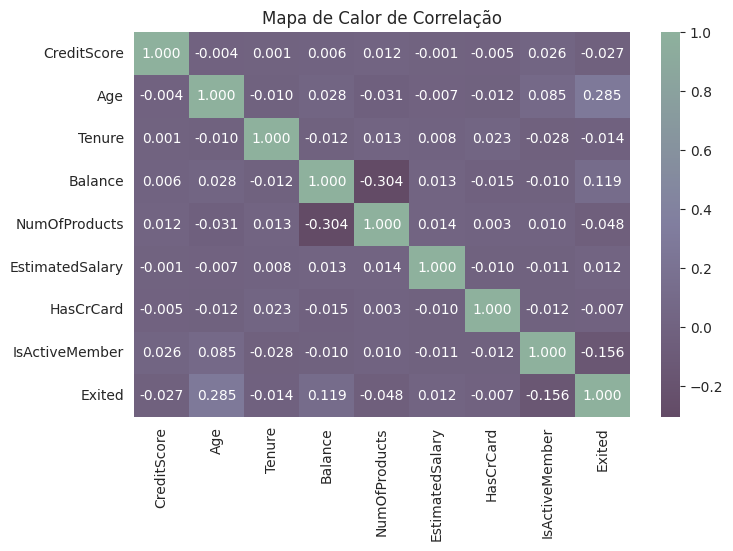

In [12]:
custom_colormap_reversed = LinearSegmentedColormap.from_list(
    "custom_cmap_reversed", 
    list(reversed(colors)), 
    N=256
)

plt.figure(figsize=(8, 5))
sns.heatmap(df[quantitatives+qualitatives].corr(numeric_only=True), annot=True, fmt=".3f", cmap=custom_colormap_reversed)
plt.title('Mapa de Calor de Correlação')
plt.show()

##### 2.3.1. Correlação da coluna "Exited" com as demais

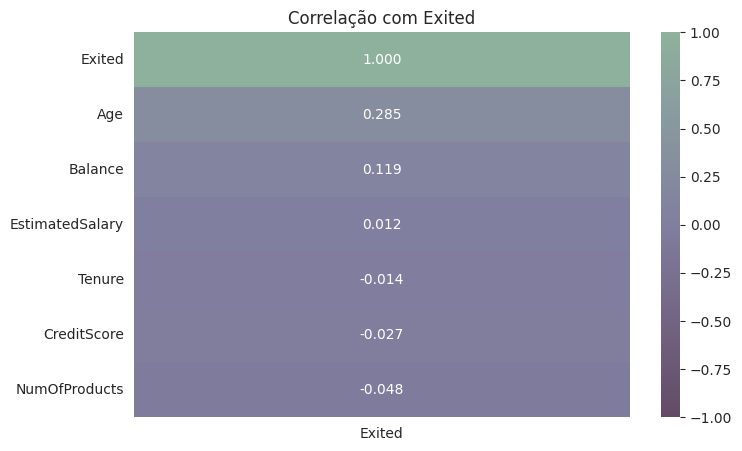

In [13]:
plt.figure(figsize=(8, 5))
sns.heatmap(df[quantitatives + ['Exited']].corr()[['Exited']].sort_values(by='Exited', ascending=False), 
            annot=True,
            fmt=".3f",
            cmap=custom_colormap_reversed,
            vmin=-1, 
            vmax=1)
plt.title('Correlação com Exited')
plt.show()

#### 2.4. Qual a relação da região com as demais variáveis e com a variável "Exited"?

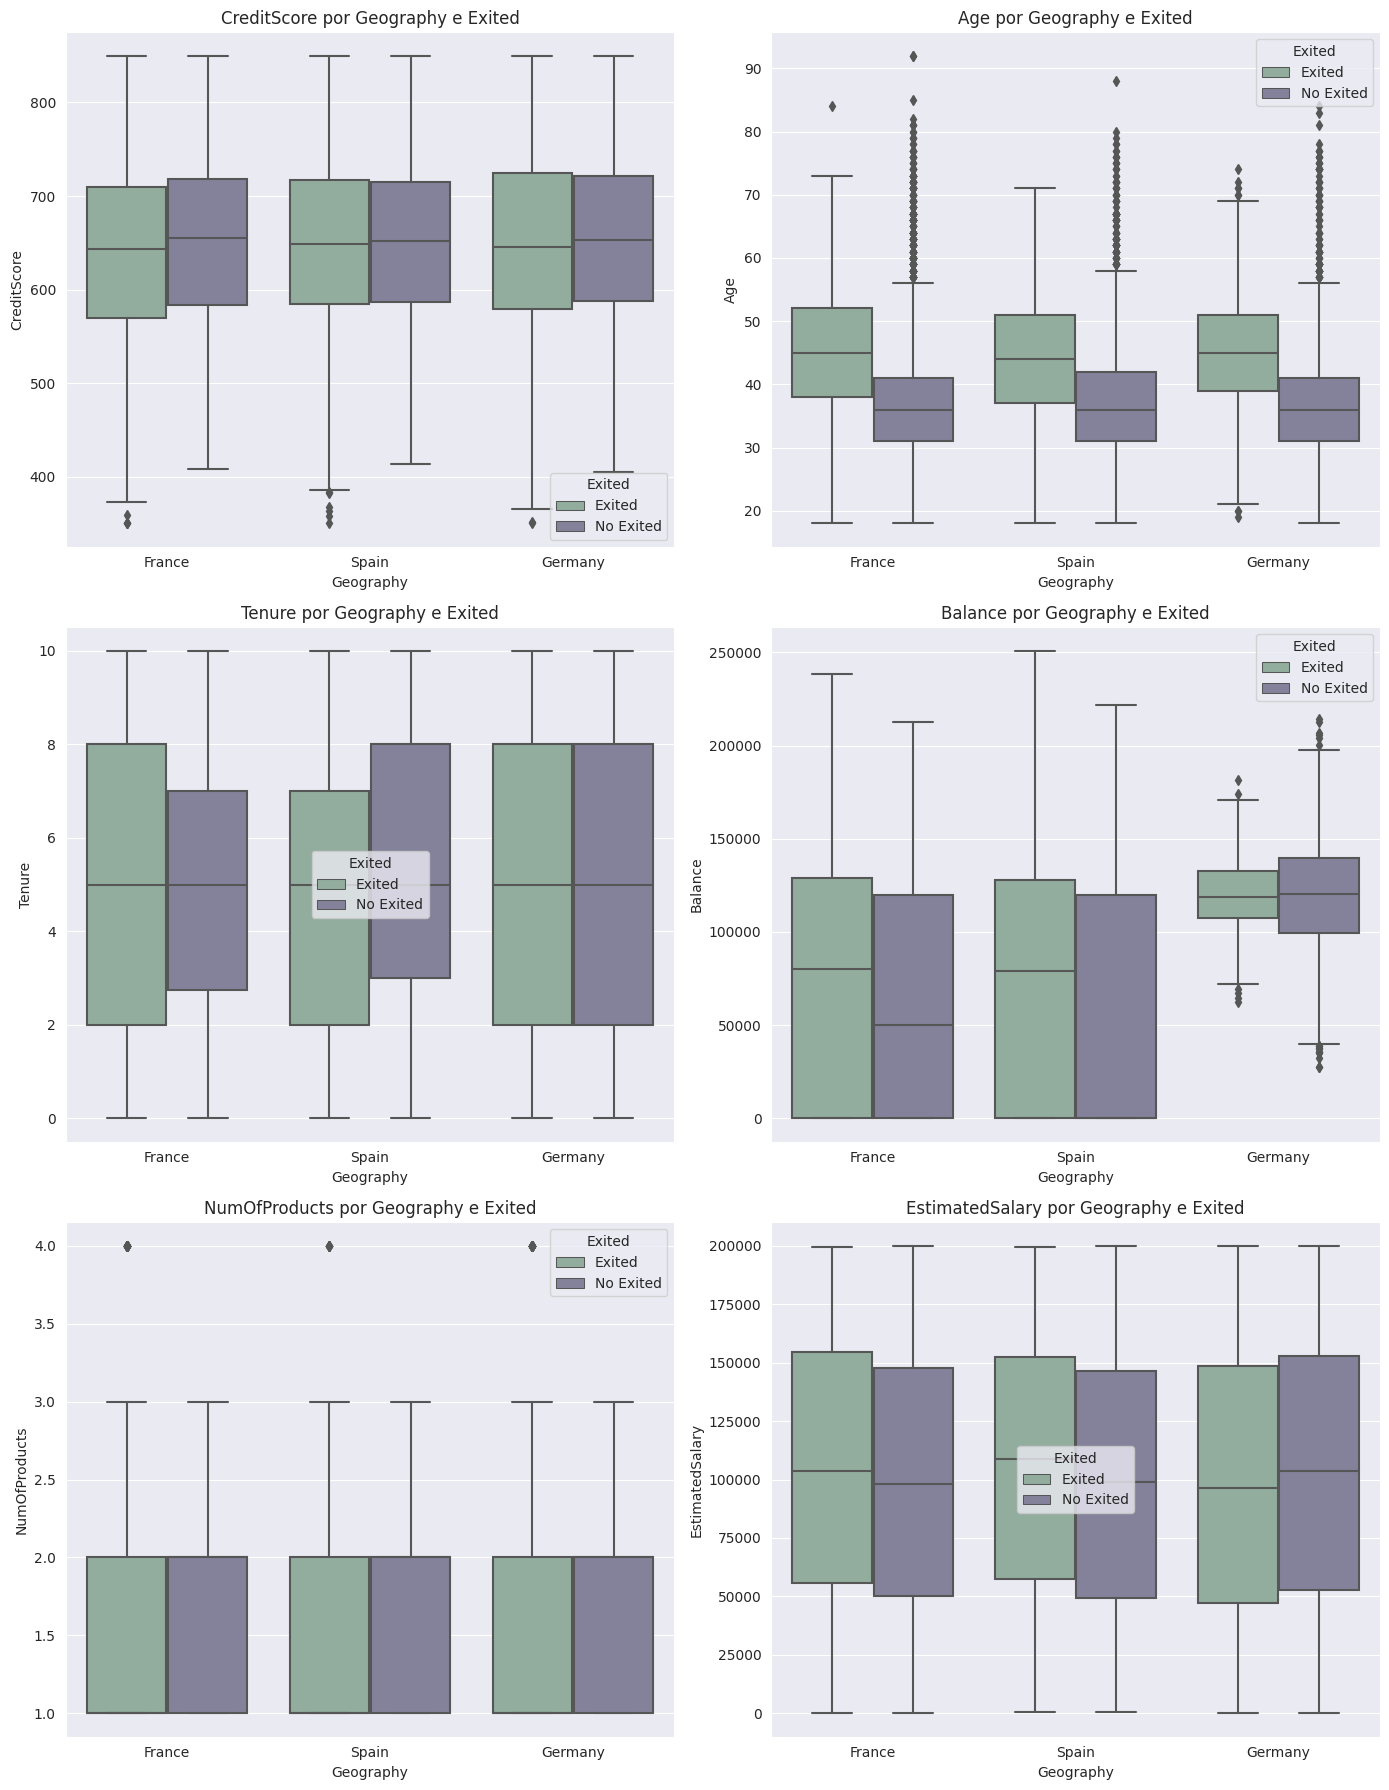

In [14]:
exited_label = df['Exited'].map({0: 'No Exited', 1: 'Exited'})

category = 'Geography'  

fig, axes = plt.subplots(nrows=3, ncols=2, figsize=(14, 18))  
axes = axes.flatten()  

for ax, col in zip(axes, quantitatives):
    sns.boxplot(x=category, y=col, hue=exited_label, data=df, ax=ax, palette=colors)  
    ax.set_title(f'{col} por {category} e Exited')
    ax.legend(title='Exited')

plt.tight_layout()
plt.show()

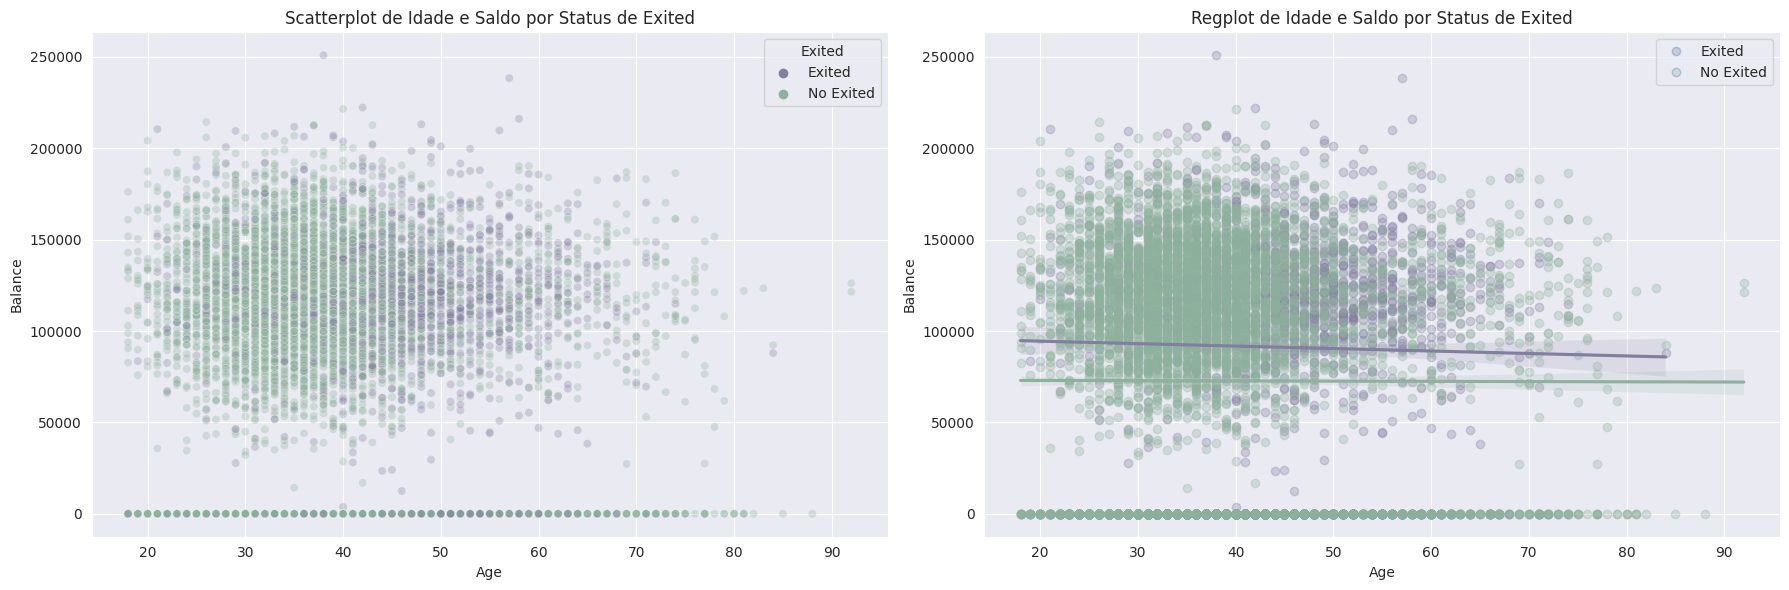

In [15]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(18, 6))

exited_color = colors[1]    
no_exited_color = colors[0] 

sns.scatterplot(x='Age', y='Balance', hue=exited_label, data=df, alpha=0.3,
                palette={'Exited': exited_color, 'No Exited': no_exited_color}, ax=ax1)
ax1.set_title('Scatterplot de Idade e Saldo por Status de Exited')

sns.regplot(x='Age', y='Balance', data=df[df['Exited'] == 1],
            scatter_kws={'alpha':0.3, 'color': exited_color}, line_kws={"color": exited_color}, ax=ax2)
sns.regplot(x='Age', y='Balance', data=df[df['Exited'] == 0],
            scatter_kws={'alpha':0.3, 'color': no_exited_color}, line_kws={"color": no_exited_color}, ax=ax2)
ax2.set_title('Regplot de Idade e Saldo por Status de Exited')

exited_marker = plt.Line2D([0], [0], linestyle='none', mfc=exited_color, marker='o', alpha=0.3)
no_exited_marker = plt.Line2D([0], [0], linestyle='none', mfc=no_exited_color, marker='o', alpha=0.3)

ax2.legend(handles=[exited_marker, no_exited_marker], labels=['Exited', 'No Exited'])

plt.tight_layout()

plt.show()

<Axes: xlabel='Age', ylabel='Density'>

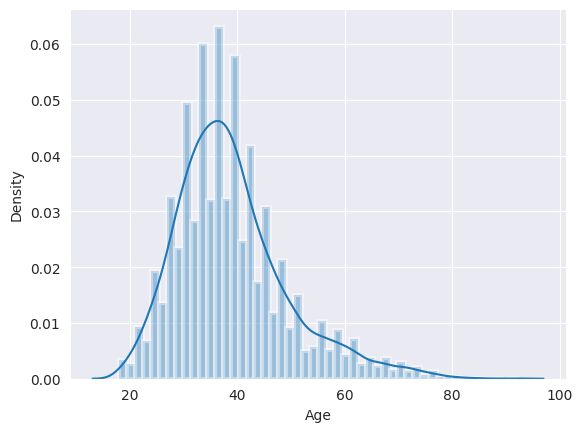

In [16]:
sns.distplot(df['Age'],hist=True,kde=True,hist_kws={'linewidth':3})

In [17]:
def pie_graph(data,title,values):
    labels = data[values].value_counts().index
    values = data[values].value_counts()
    fig = go.Figure(data=(go.Pie(labels=labels,values=values)))
    fig.update_layout(title_text = title)
    fig.show()

def split_age(age):
    if  20 >  age >= 18:
        return '18-20'
    if  30>  age >= 20:
        return '20-30'
    if  40 >  age >= 30:
        return '30-40'
    if  50 >  age >= 40:
        return '40-50'
    if  60 >  age >= 50:
        return '50-60'
    if age > 60:
        return '60+'

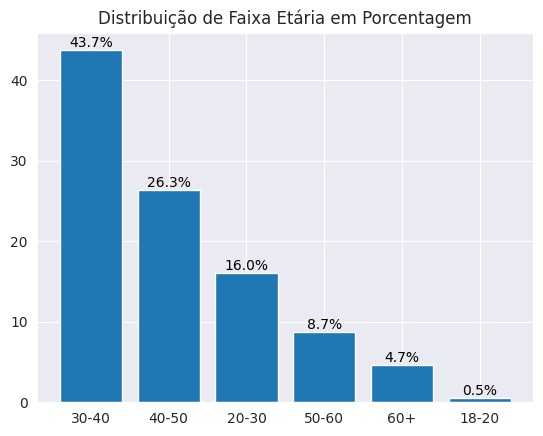

In [18]:
df_cat = pd.DataFrame()
df_cat['age_cat'] = df['Age'].apply(split_age)
df_cat['Exited'] = df['Exited']

count_data = df_cat['age_cat'].value_counts().reset_index().rename(columns={'index': 'age_cat', 'age_cat': 'count'})

count_data['percentage'] = count_data['count'] / count_data['count'].sum() * 100

plt.bar(count_data['age_cat'], count_data['percentage'])
plt.title('Distribuição de Faixa Etária em Porcentagem')

for index, row in count_data.iterrows():
    plt.text(index, row['percentage'], f'{row["percentage"]:.1f}%', color='black', ha="center", va="bottom")

plt.show()


### 3. Qual a relação entre o cliente ser um membro ativo e a saída dos clientes do banco?

Text(0.5, 1.0, 'Relação entre Churns e Atividade dos Clientes')

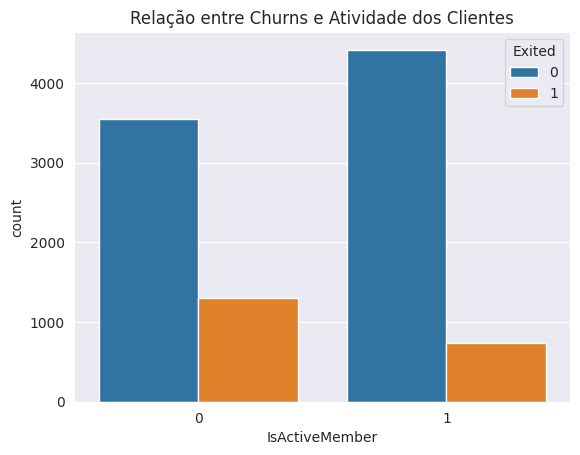

In [19]:
sns.countplot(data=df, x="IsActiveMember", hue="Exited")
plt.title('Relação entre Churns e Atividade dos Clientes')

### 4. Como a idade (Age) dos clientes se relaciona com a propensão de saída do banco?

Text(0.5, 1.0, 'Relação entre a idade do cliente e a propensão de saída do banco')

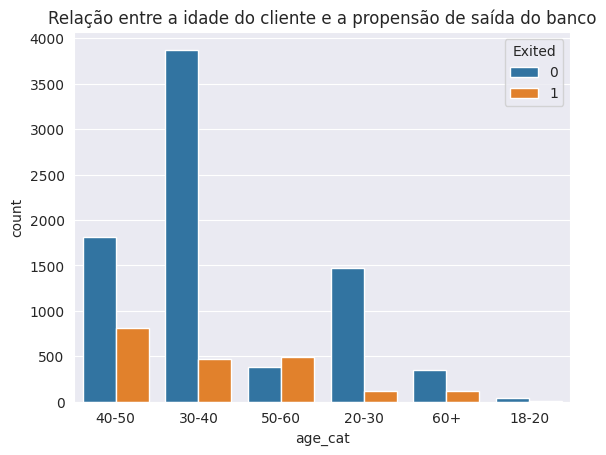

In [20]:
sns.countplot(data=df_cat, x="age_cat", hue="Exited")
plt.title('Relação entre a idade do cliente e a propensão de saída do banco')

### 5. Os clientes com salários mais altos tendem a ficar mais tempo no banco?

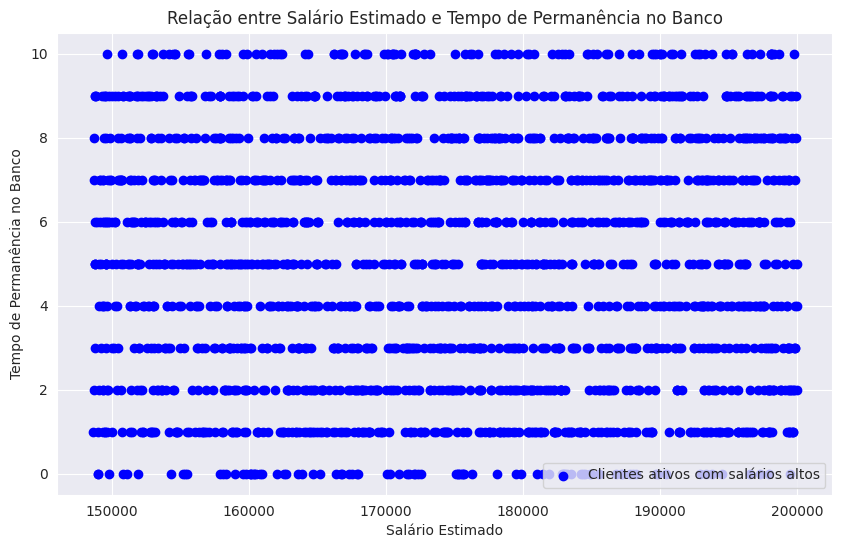

In [21]:
active_clients = df[df['Exited'] == 0]
high_salary_clients = active_clients[active_clients['EstimatedSalary'] > active_clients['EstimatedSalary'].quantile(0.75)]
plt.figure(figsize=(10, 6))
plt.scatter(high_salary_clients['EstimatedSalary'], high_salary_clients['Tenure'], color='blue', label='Clientes ativos com salários altos')
plt.xlabel('Salário Estimado')
plt.ylabel('Tempo de Permanência no Banco')
plt.title('Relação entre Salário Estimado e Tempo de Permanência no Banco')
plt.legend()
plt.grid(True)
plt.show()

### 6. A localização geográfica pode influenciar a probabilidade de um cliente sair do banco, com diferenças significativas entre regiões?

In [22]:
df_grouped = df.groupby('Geography')['Exited'].sum().reset_index()

country_codes = {
    'France': 'FRA',
    'Spain': 'ESP',
    'Germany': 'DEU'
}

df_grouped['iso_alpha_3'] = df_grouped['Geography'].map(lambda x: country_codes[x])


fig = px.choropleth(
    df_grouped,
    locations='iso_alpha_3', 
    color='Exited',  
    hover_name='Geography', 
    color_continuous_scale='Reds', 
    title='Mapa de Calor: Contagem de Churns por País',
    scope='europe'
)

fig.show()

### 7. A Média de saldo das pessoas que decidiram sair do banco e as que decidiram ficar, tem uma diferença significativa?

In [23]:
group_churn = df[df['Exited'] == 1]
group_no_churn = df[df['Exited'] == 0]

t_stat, p_value = stats.ttest_ind(group_churn['Balance'], group_no_churn['Balance'], equal_var=False)
print("\nTeste t-Student:")
print("Estatística t:", t_stat)
print("Valor p:", p_value)


Teste t-Student:
Estatística t: 12.471280320050688
Valor p: 6.318663518527974e-35


### 8. Mas será que a dispersão entre os saldos desses grupos é alto?

O desvio padrão da coluna saldo no grupo de pessoas que sairam é: 58360.794815855304
O desvio padrão da coluna saldo no grupo de pessoas que não sairam é: 62848.04070061993


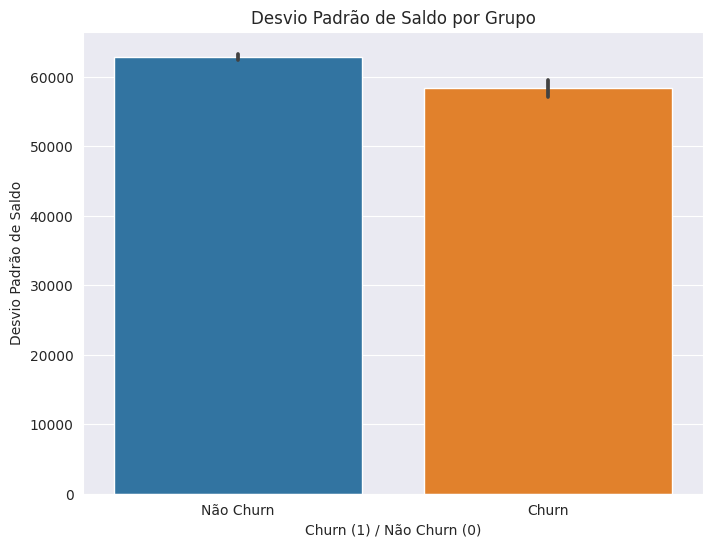

In [24]:
std_churn = group_churn['Balance'].std()
std_nochurn = group_no_churn['Balance'].std()
print('O desvio padrão da coluna saldo no grupo de pessoas que sairam é:', std_churn)
print('O desvio padrão da coluna saldo no grupo de pessoas que não sairam é:', std_nochurn)

plt.figure(figsize=(8, 6))
sns.barplot(x='Exited', y='Balance', data=df, estimator=np.std)
plt.title('Desvio Padrão de Saldo por Grupo')
plt.xlabel('Churn (1) / Não Churn (0)')
plt.ylabel('Desvio Padrão de Saldo')
plt.xticks(ticks=[0,1], labels=['Não Churn', 'Churn'])
plt.show()

In [25]:
pd.DataFrame.iteritems = pd.DataFrame.items
treemap = px.treemap(df, path=['Geography', 'Gender', 'Age', 'Balance']).show()

## 5. *Insights*

Segue o link para os insights: [Insight.md](../docs/insight.md)

## 6. Observação
- Para melhorar a análise e visualização, os dados foram tratados, incluindo a remoção das colunas (RowNumber, CustomerId, Surname).